# PREPROCESSING

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from IPython.display import clear_output

In [2]:
# load csvs to dataframe
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
len_test = len(df_test)

# we need both for the temporal features
df = pd.concat([df_train, df_test], ignore_index=True)

In [3]:
df.head()

,AssortmentType,CloudCover,Date,Events,HasPromotions,IsHoliday,IsOpen,Max_Dew_PointC,Max_Gust_SpeedKm_h,Max_Humidity,...,NumberOfCustomers,NumberOfSales,Precipitationmm,Region,Region_AreaKM2,Region_GDP,Region_PopulationK,StoreID,StoreType,WindDirDegrees
0,General,8.0,01/03/2016,Rain-Snow,0,0,1,1,NaN,100,...,495.0,5676.0,0.0,7,9643,17130,2770,1000,Hyper Market,23
1,General,8.0,02/03/2016,Snow,0,0,1,0,NaN,87,...,608.0,8111.0,0.0,7,9643,17130,2770,1000,Hyper Market,56
2,General,8.0,04/03/2016,Rain,0,0,1,0,NaN,81,...,665.0,8300.0,0.0,7,9643,17130,2770,1000,Hyper Market,22
3,General,6.0,05/03/2016,NaN,0,0,1,-3,NaN,80,...,630.0,7154.0,0.0,7,9643,17130,2770,1000,Hyper Market,108
4,General,6.0,06/03/2016,NaN,0,0,0,0,NaN,93,...,0.0,0.0,0.0,7,9643,17130,2770,1000,Hyper Market,46


In [4]:
# show sample row
df.iloc[0]

AssortmentType                     General
CloudCover                               8
Date                            01/03/2016
Events                           Rain-Snow
HasPromotions                            0
IsHoliday                                0
IsOpen                                   1
Max_Dew_PointC                           1
Max_Gust_SpeedKm_h                     NaN
Max_Humidity                           100
Max_Sea_Level_PressurehPa             1032
Max_TemperatureC                         2
Max_VisibilityKm                        19
Max_Wind_SpeedKm_h                      21
Mean_Dew_PointC                         -1
Mean_Humidity                           82
Mean_Sea_Level_PressurehPa            1030
Mean_TemperatureC                        1
Mean_VisibilityKm                       11
Mean_Wind_SpeedKm_h                     16
Min_Dew_PointC                          -2
Min_Humidity                            70
Min_Sea_Level_PressurehPa             1029
Min_Tempera

In [5]:
## Missing Values
# cloud coverage: 0 if no events, 8 if events
for row in range(len(df)):
    if row % 10000 == 0:
        clear_output()
        print("Working on row {}".format(row))
    if np.isnan(df.loc[row, 'CloudCover']):
        if df.loc[row, 'Events'] is np.nan:
            df.loc[row, 'CloudCover'] = 0
        else:
            df.loc[row, 'CloudCover'] = 8

# max gust speed = max wind speed
df.Max_Gust_SpeedKm_h = df.Max_Gust_SpeedKm_h.fillna(df.Max_Wind_SpeedKm_h)

Working on row 560000


In [6]:
## Date Features
# convert date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# add features
# df['DayN']=df['Date'].dt.dayofyear    # non credo possa servire
df['DayOfWeek']=df['Date'].dt.dayofweek
df['Month']=df['Date'].dt.month
df['Week']=df['Date'].dt.weekofyear
df['Quarter']=df['Date'].dt.quarter


In [1]:
## Temporal Features
# create columns
df['IsOpen_yesterday'] = np.empty(len(df))
df['IsOpen_tomorrow'] = np.empty(len(df))
df['IsHoliday_yesterday'] = np.empty(len(df))
df['IsHoliday_tomorrow'] = np.empty(len(df))
df['NumberOfSales_yesterday'] = np.empty(len(df))
df['NumberOfSales_lastweek'] = np.empty(len(df))
df['NumberOfSales_lastmonth'] = np.empty(len(df))

for store in df.StoreID.unique():
    clear_output()
    print("Working on {}".format(store))
    temp = df.loc[df.StoreID == store]
    # switch index to timestamps to make this easier
    oldindex = temp.index
    temp.index = temp['Date']
    
    temp['IsOpen_yesterday'] = temp.IsOpen.rolling(window='1d',closed='left', min_periods=1).sum()
    temp['IsOpen_tomorrow'] = temp.IsOpen.rolling(window='1d',closed='left', min_periods=1).sum().shift(-2, '1d')
    temp['IsHoliday_yesterday'] = temp.IsHoliday.rolling(window='1d',closed='left', min_periods=1).sum()
    temp['IsHoliday_tomorrow'] = temp.IsHoliday.rolling(window='1d',closed='left', min_periods=1).sum().shift(-2, '1d')
    temp['NumberOfSales_yesterday'] = temp.NumberOfSales.rolling(window='1d',closed='left', min_periods=1).sum()
    temp['NumberOfSales_lastweek'] = temp.NumberOfSales.rolling(window='7d',closed='left', min_periods=1).sum()
    temp['NumberOfSales_lastmonth'] = temp.NumberOfSales.rolling(window='30d',closed='left', min_periods=1).sum()
    
    # put it back in the dataframe
    temp.index = oldindex
    df.loc[df.StoreID == store] = temp
    
# Attenzione: i valori di tomorrow nel test sono sputtanati a NaN
# vanno messi a mano qui o cambiato il modo di calcolo
    
# drop rows at the beginning where we have no past information
# NB: possiamo fare a meno se togliamo quelle feature
df = df.iloc[30:]

In [ ]:
# One-Hot Encoding
# nb: pd.get_dummies rimuove le colonne direttamente

# ## StoreId
# df = pd.get_dummies(df, columns=['StoreID'], prefix='StoreID')

 ## StoreType
# df = pd.get_dummies(df, columns=['StoreType'], prefix='StoreType')

 ## AssortmentType
# df = pd.get_dummies(df, columns=['AssortmentType'], prefix='AssortmentType')

# ## Region
# df = pd.get_dummies(df, columns=['Region'], prefix='Region')

# ## Events
# df = pd.get_dummies(df, columns=['Events'], prefix='Events', dummy_na=True)
### inutile se possiamo usare categorie con decision tree

# numeric features to categories (strings)
# df.StoreID = df.StoreID.astype(str)
# df.Region = df.Region.astype(str)


In [ ]:
# Drop useless columns
df = df.drop('Date', axis=1)
df = df.drop('NumberOfCustomers', axis=1)  
df = df.drop('WindDirDegrees', axis=1)

# questi non cambiano mai, teniamo regione e population
df = df.drop('Region_AreaKM2', axis=1)
df = df.drop('Region_GDP', axis=1)
#df = df.drop('Region_PopulationK', axis=1)

In [ ]:
# Drop rows with IsOpen = 0
# -> number of sales is always = 0 
df = df[df.IsOpen == 1]

In [ ]:
df.head()

In [ ]:
print(list(df.columns))

In [ ]:
# save preprocessed data
df[:-len_test].to_csv('preprocessed_train.csv',index=False)
df[-len_test:].to_csv('preprocessed_test.csv', index=False)

In [13]:
### REMEMBER
# le sales di testing vanno aggiunte e sistemate a runtime

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# Features selection

In [19]:

df = pd.read_csv('preprocessed_train.csv')


In [20]:
# Sistemo i dati per regression tree

# One-Hot Encoding 
# nb: pd.get_dummies rimuove le colonne direttamente

# ## StoreId
# df = pd.get_dummies(df, columns=['StoreID'], prefix='StoreID')

df.drop('StoreID',axis=1)

 ## StoreType
df = pd.get_dummies(df, columns=['StoreType'], prefix='StoreType')

 ## AssortmentType
df = pd.get_dummies(df, columns=['AssortmentType'], prefix='AssortmentType')

# ## Region
df = pd.get_dummies(df, columns=['Region'], prefix='Region')

# ## Events
# df = pd.get_dummies(df, columns=['Events'], prefix='Events', dummy_na=True)
### inutile se possiamo usare categorie con decision tree

# numeric features to categories (strings)
#df.StoreID = df.StoreID.astype(str)
#df.Region = df.Region.astype(str)

In [21]:
df.iloc[0]

CloudCover                                             6
Events                                     Fog-Rain-Snow
HasPromotions                                          1
IsHoliday                                              1
IsOpen                                                 0
Max_Dew_PointC                                         0
Max_Gust_SpeedKm_h                                    14
Max_Humidity                                         100
Max_Sea_Level_PressurehPa                           1009
Max_TemperatureC                                       4
Max_VisibilityKm                                      11
Max_Wind_SpeedKm_h                                    14
Mean_Dew_PointC                                       -2
Mean_Humidity                                         78
Mean_Sea_Level_PressurehPa                          1008
Mean_TemperatureC                                      1
Mean_VisibilityKm                                      7
Mean_Wind_SpeedKm_h            

In [22]:
# No-Events (NaN) are considered as sunny days, with lowest value (0) on the events scale
df['Events'] = df['Events'].fillna(0)

In [23]:
df=df.replace({'Rain':1, 'Thunderstorm':1, 'Fog':1, 'Snow': 2, 'Fog-Rain': 2, 'Rain-Thunderstorm': 2, 'Rain-Snow':2, 'Fog-Snow':2, 'Fog-Rain-Snow':3, 'Rain-Hail':3, 'Snow-Hail':3, 'Rain-Snow-Hail':3, 'Fog-Rain-Hail':3, 'Fog-Thunderstorm':3, 'Fog-Rain-Thunderstorm':4, 'Fog-Snow-Hail':4, 'Fog-Rain-Snow-Hail':4, 'Rain-Snow-Thunderstorm':4, 'Rain-Hail-Thunderstorm':4, 'Fog-Rain-Hail-Thunderstorm':4, 'Rain-Snow-Hail-Thunderstorm':4})

df['Events'].unique()

array([3, 0, 2, 1, 4])

In [24]:
df.iloc[0]

CloudCover                                      6.0
Events                                          3.0
HasPromotions                                   1.0
IsHoliday                                       1.0
IsOpen                                          0.0
Max_Dew_PointC                                  0.0
Max_Gust_SpeedKm_h                             14.0
Max_Humidity                                  100.0
Max_Sea_Level_PressurehPa                    1009.0
Max_TemperatureC                                4.0
Max_VisibilityKm                               11.0
Max_Wind_SpeedKm_h                             14.0
Mean_Dew_PointC                                -2.0
Mean_Humidity                                  78.0
Mean_Sea_Level_PressurehPa                   1008.0
Mean_TemperatureC                               1.0
Mean_VisibilityKm                               7.0
Mean_Wind_SpeedKm_h                             6.0
Min_Dew_PointC                                 -3.0
Min_Humidity

In [97]:
# split trainset in data and target
y = df["NumberOfSales"]
X = df.drop('NumberOfSales', axis=1)

In [119]:
# Looking for features with NaN values
null_cols = []
print('Features with NaN:')
for col in X.columns:
    if X[col].isnull().values.any():
        print(col)
        null_cols.append(col)

Features with NaN:


In [100]:
# getting indices (rows) of all NaN values
inds = pd.isnull(X).any(1).nonzero()[0]

In [101]:
# drop all the rows with NaN values
y = y.drop(y.index[inds])
X = X.drop(X.index[inds])

In [106]:
# checking shapes
print('X: ' + str(X.shape))
print('y: ' + str(y.shape))

X: (509034, 56)
y: (509034,)


## Forest-Based features selection

In [107]:
# fit random forest with 250 trees
forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

Feature ranking:
1. feature 4 IsOpen (0.452942)
2. feature 37 NumberOfSales_lastmonth (0.175720)
3. feature 36 NumberOfSales_lastweek (0.111491)
4. feature 35 NumberOfSales_yesterday (0.069514)
5. feature 2 HasPromotions (0.069014)
6. feature 31 IsOpen_yesterday (0.032198)
7. feature 27 DayOfWeek (0.009026)
8. feature 23 NearestCompetitor (0.005028)
9. feature 26 StoreID (0.004834)
10. feature 29 Week (0.004728)
11. feature 32 IsOpen_tomorrow (0.004465)
12. feature 38 StoreType_Hyper Market (0.003667)
13. feature 34 IsHoliday_tomorrow (0.003395)
14. feature 28 Month (0.003359)
15. feature 33 IsHoliday_yesterday (0.002364)
16. feature 45 Region_0 (0.001942)
17. feature 8 Max_Sea_Level_PressurehPa (0.001651)
18. feature 20 Min_Sea_Level_PressurehPa (0.001599)
19. feature 42 AssortmentType_General (0.001584)
20. feature 17 Mean_Wind_SpeedKm_h (0.001584)
21. feature 50 Region_5 (0.001548)
22. feature 14 Mean_Sea_Level_PressurehPa (0.001542)
23. feature 30 Quarter (0.001532)
24. feature 9 M

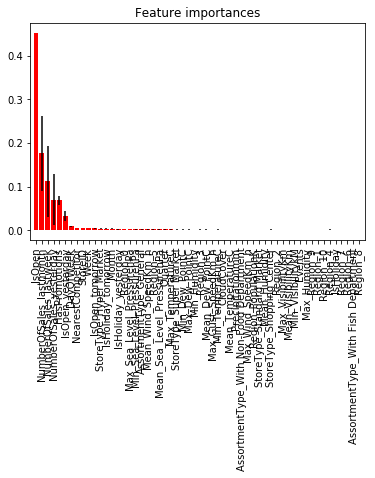

In [110]:
# preso pari pari dal notebook di Lanzi

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
feature_selection_model = SelectFromModel(forest, prefit=True)

In [ ]:
X_selected_features_forest = feature_selection_model.transform(X)
X_selected_features_forest.shape

## PCA features selection

In [113]:
from sklearn.decomposition import PCA
%matplotlib inline

full_pca_model = PCA()
full_fitted_model = full_pca_model.fit(X)

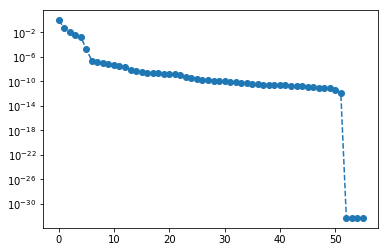

In [114]:
plt.semilogy(full_fitted_model.explained_variance_ratio_, '--o');

Text(0,0.5,'Cumulative Explained Variance Ratio')

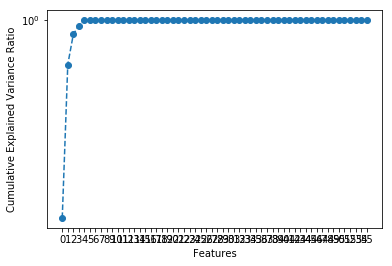

In [117]:
#Looking for a knee on the plot
plt.semilogy(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,56,1));
plt.xlabel("Features")
plt.ylabel("Cumulative Explained Variance Ratio")

In [118]:
# getting Principal (n) Components and reducing the dataset
feature_selection_pca_model = PCA(n_components=5)
fitted_model = feature_selection_pca_model.fit(X)
X_selected_features_pca = fitted_model.transform(X)
print("Explained Variance: %s" % fitted_model.explained_variance_ratio_)
print("Reduced data set shape is ", X_selected_features_pca.shape)

Explained Variance: [ 0.93088033  0.05318771  0.01084148  0.00310474  0.00196642]
Reduced data set shape is  (509034, 5)


# Cross Validation

In [ ]:
#custom region error
def region_error(region):
    #TODO
    